In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 13 01:03:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [11]:

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [12]:
import os
import math
import numpy as np
import librosa
import json
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras
from keras.utils import plot_model
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.svm import SVC
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Audio
from scipy.io import wavfile
import scipy
import soundfile as sf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from pydub import AudioSegment
import random

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
import os

base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
#sound_dir = os.path.join(base_dir, 'Sound_1_Sec_5_Files')

image_dir = os.path.join(base_dir,  'Mel_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

# Check if the train_dir exists
if os.path.exists(image_dir):
  if os.path.exists(train_dir):
    if os.path.exists(test_dir):
      print(f"train_dir exists: {image_dir}")
  else:
    print(f"train_dir does not exist: {train_dir}")

#train_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Train"
#test_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Test"



# List files in the train directory
train_files = os.listdir(train_dir)
print(f"Files in train directory: {train_files}")  # Print all files
print(f"Number of files in train directory: {len(train_files)}")

# List files in the test directory
test_files = os.listdir(test_dir)
print(f"Files in test directory: {test_files}")  # Print all files
print(f"Number of files in test directory: {len(test_files)}")


train_dir exists: /content/drive/MyDrive/ASE_Dataset_Folder/Mel_Images_1_Sec
Files in train directory: ['Explosion', 'Emergency_alarm', 'Gun_Shots', 'glass_breaking', 'thunderstorm', 'dog', 'wind', 'Earthquake', 'Flood', 'Tsunami', 'Volcanic Eruption', 'Dam Failure', 'Wildfire']
Number of files in train directory: 13
Files in test directory: ['Gun_Shots', 'Emergency_alarm', 'Explosion', 'dog', 'glass_breaking', 'thunderstorm', 'wind', 'Flood', 'Earthquake', 'Tsunami', 'Volcanic Eruption', 'Dam Failure', 'Wildfire']
Number of files in test directory: 13


In [14]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1

hop_size_sec = hop_length / sr
audio_length_samples = T * sr

width = 1 + int((audio_length_samples - n_fft) / hop_length)

channels = 3


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output the results
print(f"Found {train_generator.samples} images for training.")
print(f"Found {test_generator.samples} images for testing.")

# Check if generators are yielding data
if len(train_generator) == 0:
    raise ValueError(f"Train generator is empty. Check the directory: {train_dir}")
if len(test_generator) == 0:
    raise ValueError(f"Test generator is empty. Check the directory: {test_dir}")


cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cnn_model.add(tf.keras.layers.Flatten())

# RNN model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Reshape((width, height * channels), input_shape=(height, width, channels)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),
    tf.keras.layers.BatchNormalization()
])

# Combine CNN and RNN models
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, height, width, channels), input_shape=(height, width, channels)),
    tf.keras.layers.TimeDistributed(cnn_model),  # TimeDistributed applies the CNN model to each time step
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),  # RNN on top of CNN features
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall', 'f1_score'])

epochs = 200
metrics_data = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_generator.reset()

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        verbose=1,
        validation_data=test_generator,
        validation_steps=len(test_generator))

    # Get metrics from history
    accuracy = history.history['accuracy'][0]
    precision = history.history['precision'][0]
    recall = history.history['recall'][0]

    f1_score_tensor = history.history['f1_score'][0]
    f1_score_value = np.mean(f1_score_tensor)

    # Store metrics in a list
    metrics_data.append([accuracy, precision, recall, f1_score_value])

model.save('/content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/al-emadi_crnn_standardized_final_test.keras')




Found 3015 images belonging to 13 classes.
Found 1351 images belonging to 13 classes.
Found 3015 images for training.
Found 1351 images for testing.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 3120s 33s/step - accuracy: 0.2219 - f1_score: 0.0964 - loss: 2.3993 - precision: 0.2402 - recall: 0.0030 - val_accuracy: 0.4412 - val_f1_score: 0.1493 - val_loss: 1.8838 - val_precision: 0.7432 - val_recall: 0.2443
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 524ms/step - accuracy: 0.4145 - f1_score: 0.1584 - loss: 1.8904 - precision: 0.7923 - recall: 0.1682 - val_accuracy: 0.4456 - val_f1_score: 0.1343 - val_loss: 1.5835 - val_precision: 0.6488 - val_recall: 0.3583
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 520ms/step - accuracy: 0.4890 - f1_score: 0.2355 - loss: 1.6325 - precision: 0.8391 - recall: 0.2649 - val_accuracy: 0.5026 - val_f1_score: 0.1832 - val_loss: 1.4978 - val_precision: 0.7185 - val_recall: 0.4515
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 518ms/step - accuracy: 0.5482 - f1_score: 0.3147 - loss: 1.4249 - precision: 0.8398 - recall: 0.3455 - val_accuracy: 0.5477 - val_f1_score: 0.2672 - val_loss: 1.3063 - val_precision: 0.8699 - val_recall: 0.4

In [1]:
model.save('/content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/al-emadi_crnn_standardized_final_test.keras')


NameError: name 'model' is not defined

In [15]:
import csv

# Save metrics to a CSV file
csv_filename = '/content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/training_metrics_2_test.csv'

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    writer.writerows(metrics_data)

print(f"Training metrics saved to {csv_filename}")

loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

Training metrics saved to /content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/training_metrics_2_test.csv
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.8165 - f1_score: 0.4272 - loss: 0.8675 - precision: 0.8277 - recall: 0.8076
Test Loss: 0.7683002352714539
Test Accuracy: 0.8564026355743408
Test Precision: 0.8651092648506165
Test Recall: 0.8497409224510193
Test F1 Score: tf.Tensor(
[0.21052629 0.85558575 0.89411753 0.60377353 0.8979592  0.87323934
 0.79999995 0.7342995  0.9937733  0.81999993 0.74324316 0.69811314
 0.84285706], shape=(13,), dtype=float32)


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Model and directories configuration
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)
channels = 3
batch_size = 32

# Load the pre-trained model
model_path = '/content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/al-emadi_crnn_standardized_final_test.keras'
model = tf.keras.models.load_model(model_path)

# Test Data Generator
test_datagen = ImageDataGenerator()
test_dir = '/content/drive/MyDrive/ASE_Dataset_Folder/Mel_Images_1_Sec/Test/Sounds'  # Ensure this path is correct
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Evaluate the model
results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
if len(results) > 2:
    print(f"Additional Metrics:")
    for metric, value in zip(model.metrics_names[2:], results[2:]):
        print(f"{metric.capitalize()}: {value}")

# Predicting classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True class indices
true_classes = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Calculate accuracy for each class
class_accuracy = {}
for i, class_label in enumerate(class_labels):
    correct_indices = np.where(true_classes == i)[0]
    correct_predictions = np.sum(predicted_classes[correct_indices] == i)
    total_samples = len(correct_indices)
    class_accuracy[class_label] = correct_predictions / total_samples if total_samples > 0 else 0.0

# Print accuracy for each class
print("\nAccuracy for each class:")
for class_label in class_labels:
    print(f"{class_label}: {class_accuracy[class_label]:.4f}")


Found 1351 images belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - accuracy: 0.8165 - f1_score: 0.4272 - loss: 0.8675 - precision: 0.8277 - recall: 0.8076
Test Loss: 0.7683002352714539
Test Accuracy: 0.8564026355743408
Additional Metrics:
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step

Confusion Matrix:
[[  2   4   0   2   0   1   1   1   1   0   1   0   0]
 [  3 157   0   7   0   1   1   3   2   0  10   1   0]
 [  0   1 114   4   1   0   0   0   0   1   2   0   1]
 [  0   4   4  48   0   1   2   3   1   1   4   7   3]
 [  0   0   0   1  66   1   1   0   0   0   7   0   0]
 [  1   0   1   0   0  31   0   0   0   0   1   0   1]
 [  0   1   1   2   1   0  72   6   0   0   1   0   5]
 [  0  10   0   9   1   0  10  76   0   0   2   3   0]
 [  0   0   0   0   0   0   0   0 399   0   0   0   1]
 [  0   0   8   1   0   0   0   1   0  41   5   0   0]
 [  0   0   3   1   1   0   0   0   0   0  55   0   0]
 [  0   3   0   4   0   1   3   5   0   1   0  37   4]
 [  0   2   0   2   1   0   1   1   0   0   0   0  59]]

Classi

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.8165 - f1_score: 0.4272 - loss: 0.8675 - precision: 0.8277 - recall: 0.8076

Evaluation Results:
loss: 0.7683
compile_metrics: 0.8564
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step


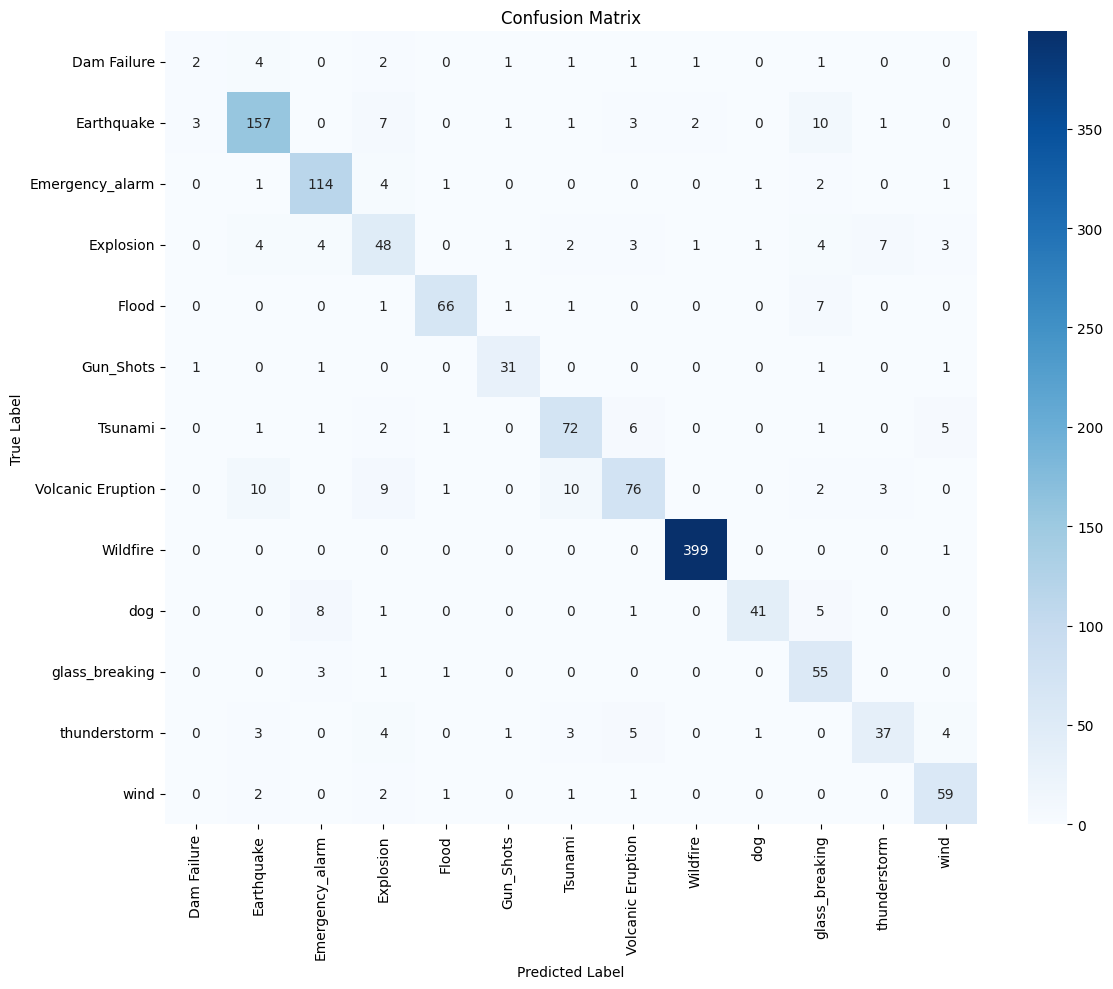

<ipython-input-4-a152dd007cb9>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_accuracy, palette='viridis')


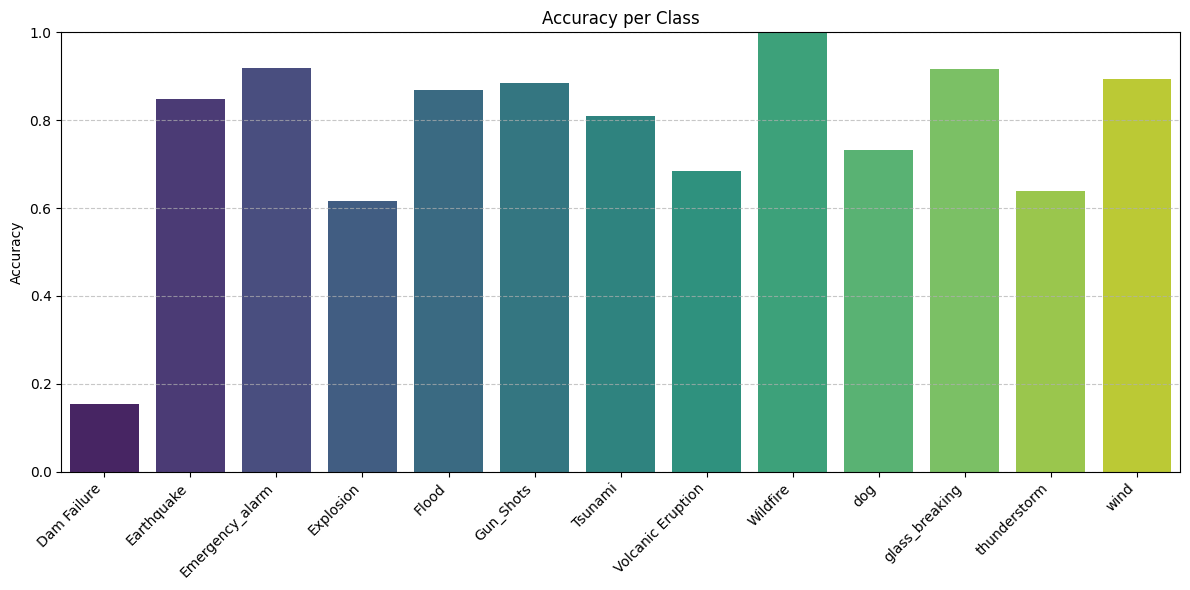

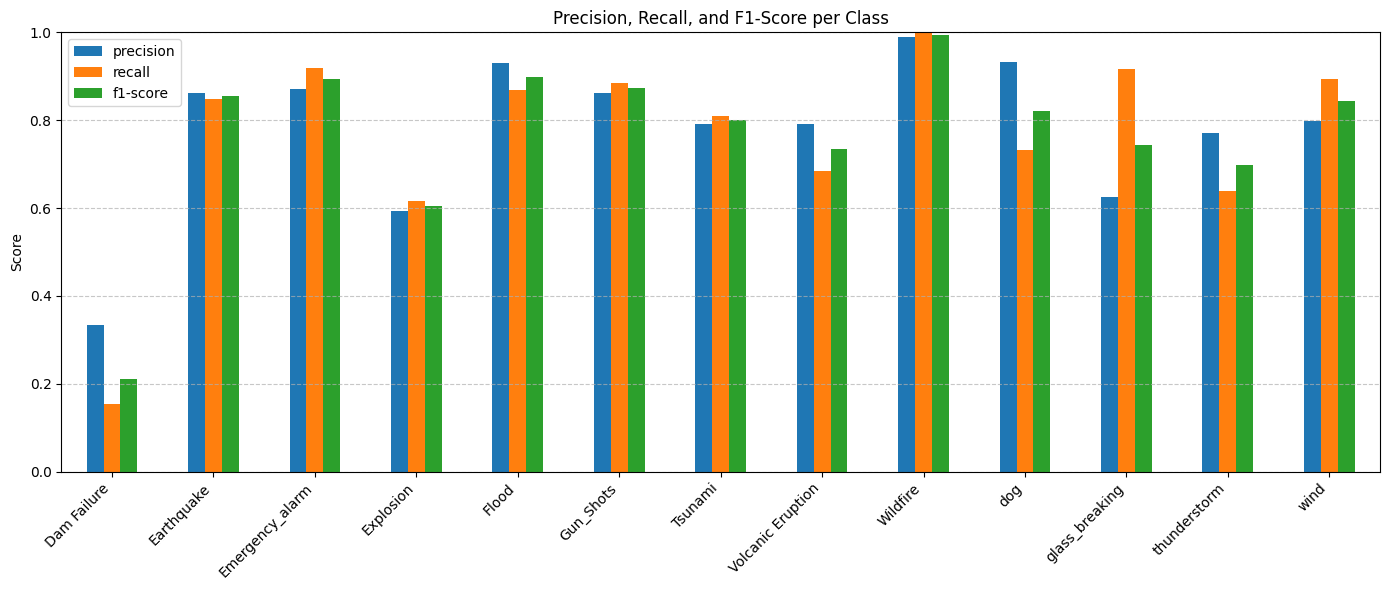

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Evaluation ---
model = tf.keras.models.load_model(model_path)
results = model.evaluate(test_generator)
print("\nEvaluation Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions and Reports
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3]  # exclude avg rows

# --- Visualization ---
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
class_accuracy = (np.diag(conf_matrix) / conf_matrix.sum(axis=1)).tolist()
sns.barplot(x=class_labels, y=class_accuracy, palette='viridis')
plt.title('Accuracy per Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(14, 6))
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


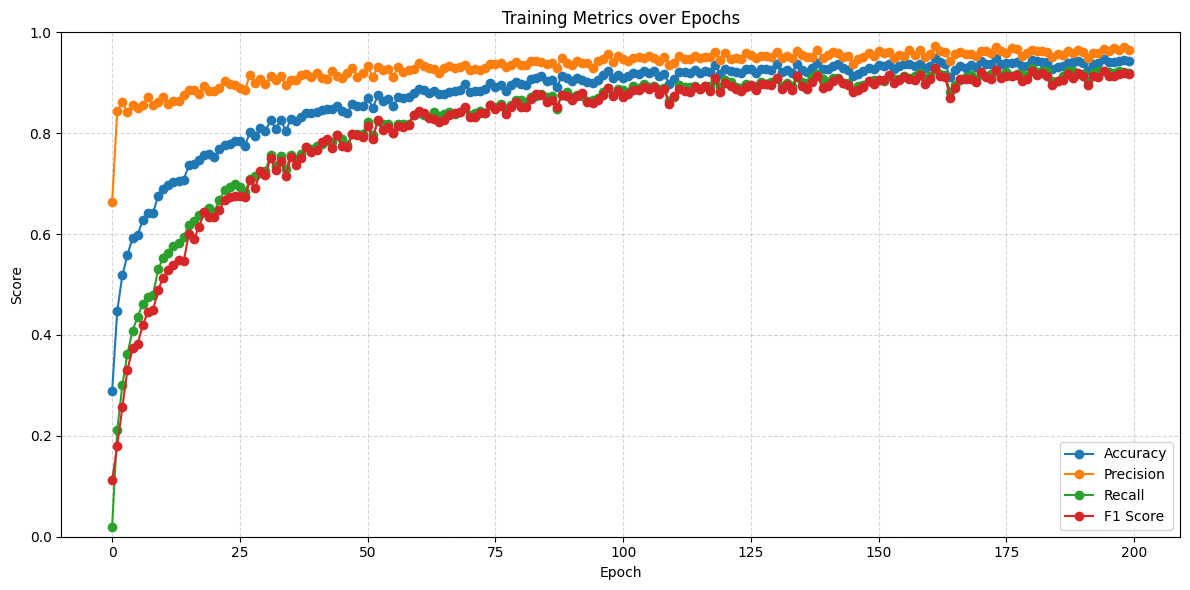

In [5]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CRNN/MEL_CRNN_FOLDER/Final_Test/training_metrics_2_test.csv')
df.plot(figsize=(12, 6), marker='o')
plt.title('Training Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
